In [20]:
from ipypb import track as tqdm
import torch
import matplotlib.pyplot as plt
import numpy as np
import itertools
import numba
import random
import diffplan
import astar
import envs
import prior_envs
import heapq
import joblib
from IPython.display import display
%load_ext autoreload
%autoreload 2
%matplotlib inline

eps = torch.finfo().eps

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [249]:
figsize = 2

def _plot_graph_best(env, d, row=None, **kw):
    row = row or max(d, key=lambda row: row['value'])
    t = torch.zeros(len(env.states))
    for o in row['options']:
        t[o] = 1
    return diffplan.plot_graph(env, z=t, size=figsize, goal_set=set(), **kw)

def visualize_enum(env, sc=None, num_options=1, beta=1.):
    if sc is None:
        D = diffplan.compute_distance_matrix(env)
        BFS = diffplan.compute_bfs_matrix(env, D)
        sc = D+BFS
    d=diffplan.option_learner_enum(env, search_cost=sc, num_options=num_options, option_planner_bfs_vec=diffplan.option_planner_hardmax, top_results=10)
    return show_computed_enum(env, d, beta=beta)

def show_computed_enum(env, d, beta=1.):
    logit_option = torch.zeros(len(env.states))
    for row in d:
        if len(row['options']) != 1:
            print('Found ', row)
            continue
        logit_option[row['options'][0]] = row['value']
    return diffplan.plot_graph(env, z=(beta*logit_option).softmax(0), size=figsize)

def show_computed_enum_manyopt(env, d):
    logit_option = torch.zeros(len(d))
    for idx, row in enumerate(d):
        logit_option[idx] = row['value']

    p = logit_option.softmax(0)
    summed = torch.zeros(len(env.states))
    for idx, row in enumerate(d):
        for s in row['options']:
            summed[s] += p[idx]
    return diffplan.plot_graph(env, z=summed, size=figsize)

In [237]:
env = prior_envs.f2a
D = diffplan.compute_distance_matrix(env)
BFS = diffplan.compute_bfs_matrix(env, D)
d=diffplan.option_learner_enum(env, search_cost=D+BFS, num_options=3, option_planner_bfs_vec=diffplan.option_planner_hardmax, tqdm=tqdm, top_results=10)
print(next(row for row in d if row['options'] == ()))

 [████████████████████████████████████████████████████████████] 456/456 [00:13<00:00, 0.03s/it]

{'options': (3, 9, 13), 'value': -9.49333324432373}
{'options': (4, 8, 14), 'value': -9.49333324432373}
{'options': (3, 4, 9), 'value': -9.493333435058593}
{'options': (3, 4, 14), 'value': -9.493333435058593}
{'options': (3, 13, 14), 'value': -9.493333435058593}
{'options': (4, 8, 9), 'value': -9.493333435058593}
{'options': (8, 9, 13), 'value': -9.493333435058593}
{'options': (8, 13, 14), 'value': -9.493333435058593}
{'options': (0, 3, 4), 'value': -9.51111125946045}
{'options': (1, 3, 4), 'value': -9.51111125946045}
{'options': (), 'value': -9.733333587646484}


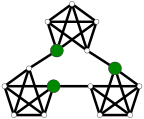

'figures/td-shapiro-o3-bfs-example.pdf'

In [238]:
g = _plot_graph_best(env, d)
display(g)
g.render('figures/td-shapiro-o3-bfs-example')

{'options': (0,), 'value': -7.360000228881836}
{'options': (1,), 'value': -7.360000228881836}
{'options': (2,), 'value': -7.360000228881836}
{'options': (3,), 'value': -7.360000228881836}
{'options': (4,), 'value': -7.360000228881836}
{'options': (5,), 'value': -7.360000228881836}
{'options': (6,), 'value': -7.360000228881836}
{'options': (7,), 'value': -7.360000228881836}
{'options': (8,), 'value': -7.360000228881836}
{'options': (9,), 'value': -7.360000228881836}
Found  {'options': (), 'value': -7.360000228881836}


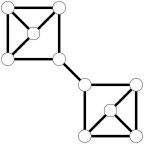

'figures/td-solway2c.pdf'

In [239]:
env = prior_envs.f2c
g = visualize_enum(env)
display(g)
g.render('figures/td-solway2c')

{'options': (9,), 'value': -12.786703511288291}
{'options': (2,), 'value': -12.795013929668226}
{'options': (8,), 'value': -12.795013929668226}
{'options': (10,), 'value': -12.795013929668226}
{'options': (16,), 'value': -12.795013929668226}
{'options': (5,), 'value': -12.80332404688785}
{'options': (13,), 'value': -12.80332404688785}
{'options': (1,), 'value': -12.814404387223092}
{'options': (7,), 'value': -12.814404387223092}
{'options': (11,), 'value': -12.814404387223092}
Found  {'options': (), 'value': -12.908587305169357}


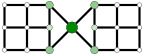

'figures/td-solway2d.pdf'

In [240]:
env = prior_envs.f2d
g = visualize_enum(env, beta=100)
display(g)
g.render('figures/td-solway2d')

# hanoi

In [71]:
env = prior_envs.f2f

h = envs.compute_blocks_distance_heuristic(env)
a_star_distance, a_star_cost = astar.compute_astar_matrix(env, h, samples=100, tqdm=tqdm)
hanoi_sc = a_star_distance + a_star_cost

 [████████████████████████████████████████████████████████████] 27/27 [01:19<00:03, 2.92s/it]

In [128]:
env = prior_envs.f2f
d=diffplan.option_learner_enum(env, search_cost=hanoi_sc, num_options=3, option_planner_bfs_vec=diffplan.option_planner_hardmax, tqdm=tqdm, top_results=10)
print(next(row for row in d if row['options'] == ()))
joblib.dump(d, 'f2f-o3-hardmax-astar.bin')

 [████████████████████████████████████████████████████████████] 2926/2926 [02:17<00:00, 0.05s/it]

{'options': (3, 19, 20), 'value': -9.668395042419434}
{'options': (4, 10, 23), 'value': -9.668957392374674}
{'options': (3, 19, 23), 'value': -9.677832568133319}
{'options': (), 'value': -11.336118168301052}


['f2f-o3-hardmax-astar.bin']

In [129]:
D = diffplan.compute_distance_matrix(env)
BFS = diffplan.compute_bfs_matrix(env, D)
sc = D+BFS
d=diffplan.option_learner_enum(env, search_cost=sc, num_options=3, option_planner_bfs_vec=diffplan.option_planner_hardmax, tqdm=tqdm, top_results=10)
print(next(row for row in d if row['options'] == ()))
joblib.dump(d, 'f2f-o3-hardmax-bfs.bin')

 [████████████████████████████████████████████████████████████] 2926/2926 [03:15<00:00, 0.07s/it]

{'options': (2, 18, 20), 'value': -16.700960123980487}
{'options': (2, 19, 21), 'value': -16.700960123980487}
{'options': (3, 18, 21), 'value': -16.700960123980487}
{'options': (), 'value': -17.56378640068902}


['f2f-o3-hardmax-bfs.bin']

In [247]:
print('A*')
d = joblib.load('f2f-o3-hardmax-astar.bin')
for item in sorted(d, key=lambda row: -row['value'])[:10]:
    print(item)

print('BFS')
d = joblib.load('f2f-o3-hardmax-bfs.bin')
for item in sorted(d, key=lambda row: -row['value'])[:10]:
    print(item)

A*
{'options': (3, 19, 20), 'value': -9.668395042419434}
{'options': (4, 10, 23), 'value': -9.668957392374674}
{'options': (3, 19, 23), 'value': -9.677832568133319}
{'options': (3, 4, 23), 'value': -9.6779561219392}
{'options': (3, 4, 20), 'value': -9.684046498051396}
{'options': (10, 19, 23), 'value': -9.685912061620641}
{'options': (4, 10, 20), 'value': -9.689656964054814}
{'options': (10, 19, 20), 'value': -9.690288013882107}
{'options': (3, 23, 24), 'value': -9.925377033374927}
{'options': (3, 9, 19), 'value': -9.925431851987485}
BFS
{'options': (2, 18, 20), 'value': -16.700960123980487}
{'options': (2, 19, 21), 'value': -16.700960123980487}
{'options': (3, 18, 21), 'value': -16.700960123980487}
{'options': (4, 9, 24), 'value': -16.700960123980487}
{'options': (5, 9, 23), 'value': -16.700960123980487}
{'options': (5, 10, 24), 'value': -16.700960123980487}
{'options': (2, 19, 20), 'value': -16.717421107821995}
{'options': (3, 18, 20), 'value': -16.717421107821995}
{'options': (3, 19

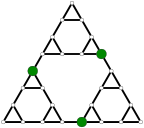

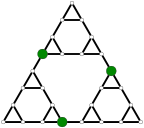

'figures/td-hanoi-o3-astar-example-other.pdf'

In [250]:
g = _plot_graph_best(prior_envs.f2f, joblib.load('f2f-o3-hardmax-astar.bin'), constant_node_size=False)
display(g)
g.render('figures/td-hanoi-o3-astar-example')

d = joblib.load('f2f-o3-hardmax-astar.bin')
row = sorted(d, key=lambda row: -row['value'])[1] # next best

g = _plot_graph_best(prior_envs.f2f, d, row=row, constant_node_size=False)
display(g)
g.render('figures/td-hanoi-o3-astar-example-other')

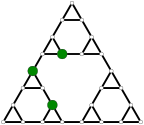

'figures/td-hanoi-o3-bfs-example.pdf'

In [242]:
g = _plot_graph_best(prior_envs.f2f, joblib.load('f2f-o3-hardmax-bfs.bin'))
display(g)
g.render('figures/td-hanoi-o3-bfs-example')

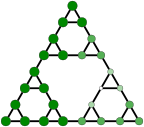

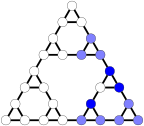

'figures/astar-heuristic.pdf'

In [243]:
g = diffplan.plot_graph(prior_envs.f2f, z=h[:, 21], size=figsize, goal_set=set())
display(g)
g.render('figures/astar-heuristic-other')

orange = (253/255, 127/255, 35/255)
blue = (0, 0, 1)

distance = h[:, 21].clone()
distance[21] = 3
g = diffplan.plot_graph(prior_envs.f2f, z=-distance, size=figsize, goal_set=set(), constant_node_size=True, rgb=blue)
display(g)
g.render('figures/astar-heuristic')

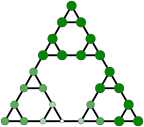

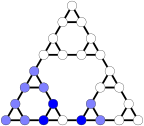

'figures/astar-heuristic-subgoal.pdf'

In [244]:
# to subgoal
state = 4

g = diffplan.plot_graph(prior_envs.f2f, z=h[:, state], size=figsize, goal_set=set())
display(g)
g.render('figures/astar-heuristic-subgoal-other')

orange = (253/255, 127/255, 35/255)
blue = (0, 0, 1)

distance = h[:, state].clone()
distance[state] = 3
g = diffplan.plot_graph(prior_envs.f2f, z=-distance, size=figsize, goal_set=set(), constant_node_size=True, rgb=blue)
display(g)
g.render('figures/astar-heuristic-subgoal')